In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import numpy as np
from qiskit.circuit import QuantumRegister

In [3]:
def convert(qc, gate, params, qregs, cregs = None):
    if gate == 'id':
        return
    elif gate == 'h': # -iH
        add_r_gate(qc, 'rz', np.pi/2, qregs[0])
        add_r_gate(qc, 'rx', np.pi/2, qregs[0])
        add_r_gate(qc, 'rz', np.pi/2, qregs[0])
    elif gate == 'x': # -iX
        add_r_gate(qc, 'rx', np.pi, qregs[0])
    elif gate == 'y': # -iY
        convert(qc, 'ry', [np.pi], qregs)
    elif gate == 'z': # -iZ
        add_r_gate(qc, 'rz', np.pi, qregs[0])
    elif gate == 'rx':
        add_r_gate(qc, 'rx', params[0], qregs[0])
    elif gate == 'ry':
        add_r_gate(qc, 'rz', np.pi/2, qregs[0])
        add_r_gate(qc, 'rx', params[0], qregs[0])
        add_r_gate(qc, 'rz', -np.pi/2, qregs[0])
    elif gate == 'rz':
        add_r_gate(qc, 'rz', params[0], qregs[0])
    elif gate == 'cx':
        convert(qc, 'h', None, [qregs[1]])
        add_cz(qc, *qregs)
        convert(qc, 'h', None, [qregs[1]])
    elif gate == 'cz':
        add_cz(qc, *qregs)
    elif gate == 'barrier':
        qc.barrier(*qregs) # qregs?
    elif gate == 'measure':
        qc.measure(qregs[0],cregs[0])

In [4]:
# 
def find_last_prev_gate(qc, i):
    for instr,qregs,_ in qc.data[::-1]:
        if instr.name not in ['barrier','measure'] and qc.qubits[i] in qregs:
            return instr
#
def remove_gate(qc, gate, i):
    # search for this gate in QCData
    for data in qc.data[::-1]:
        if data[0] == gate:
            # remove gate data
            print(f'removed {gate.name} from q{i}' + \
                          (f' with theta = {gate.params[0]//np.pi:.2f}*pi' if len(gate.params)==1 else ''))
            qc.data.remove(data)
            return

In [5]:
def add_r_gate(qc, r_gate, theta, i):
    if prev_gate[i] is not None and prev_gate[i].name == r_gate:
        print(f'merged {r_gate} on q{i}')
        prev_gate[i].params[0] += theta # repetition optimization
    else:
        prev_gate[i] = getattr(qc, r_gate)(theta, i)[0] # keep track
    # periodicity optimization, 2pi periodicity discarding global phase 
    if prev_gate[i] is not None and (prev_gate[i].params[0]/np.pi) % 2 < 1e-4:
        # remove gate and set last previous gate to prev_gate
        remove_gate(qc, prev_gate[i], i)
        prev_gate[i] = find_last_prev_gate(qc, i)
# add cz gate
def add_cz(qc, i, j):
    if prev_gate[i] is not None and prev_gate[i] is prev_gate[j]:
        remove_gate(qc, prev_gate[i], i)
        prev_gate[i] = find_last_prev_gate(qc, i)
        prev_gate[j] = find_last_prev_gate(qc, j)
    else:
        prev_gate[i] = qc.cz(i,j)[0] # keep track
        prev_gate[j] = prev_gate[i]  # on both qubit

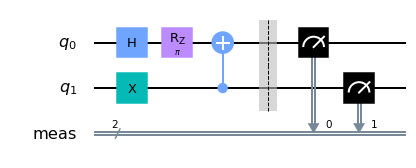

In [6]:
qc_in = QuantumCircuit(2)
qc_in.x(1)
qc_in.h(0)
qc_in.rz(np.pi, 0)
qc_in.cx(1,0)
qc_in.measure_all()
qc_in.draw()

merged rz on q0
merged rz on q0
removed rz from q0 with theta = 2.00*pi
merged rx on q0

Overhead: (+ 4) or (x 1.571)


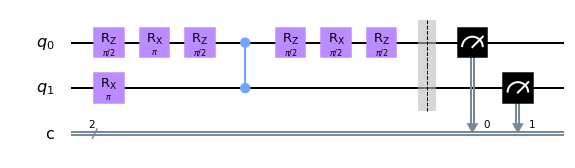

In [7]:
qdict = {qubit : i for i,qubit in enumerate(qc_in.qubits)}
cdict = {clbit : i for i,clbit in enumerate(qc_in.clbits)}
prev_gate = [None]*qc_in.num_qubits
#
qc_out = QuantumCircuit(qc_in.num_qubits, qc_in.num_clbits)
for instr,qregs,cregs in qc_in.data:
    convert(qc_out, instr.name, instr.params, 
                   [qdict[qubit] for qubit in qregs],
                   [cdict[clbit] for clbit in cregs])
print(f'\nOverhead: (+ {len(qc_out.data) - len(qc_in.data)}) or (x {len(qc_out.data) / len(qc_in.data):.3f})')
qc_out.draw()

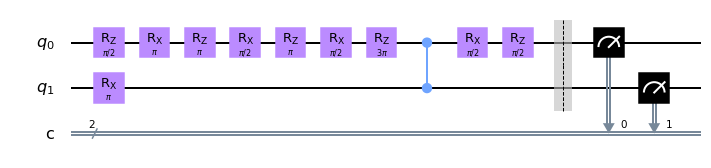

In [8]:
# comparison with transpiler
transpile(qc_out, basis_gates=['cz','rx','rz'], optimization_level=3).draw()